# 03. Machine Learning (XGBoost) & Interpretability

**Project:** Swiss Rental Price Prediction<br>
**Author:** Dimitrios Mylonas

**Objective:**
Train a non-linear Gradient Boosting model (XGBoost) to outperform the linear baseline. Use SHAP (SHapley Additive exPlanations) to interpret the model's decisions and understand the drivers of Swiss rental prices.

**Methodology:**
1.  **Data Preparation:** Encode categorical variables for Tree-based models (Target Encoding for Zip, One-Hot for others).
2.  **Model Training:** Train an XGBoost Regressor.
3.  **Hyperparameter Tuning:** Use `RandomizedSearchCV` to optimize learning rate, depth, and regularization.
4.  **Evaluation:** Compare MAE against the baseline (641 CHF).
5.  **Interpretability:** Visualize feature importance using SHAP values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import category_encoders as ce

# Configuration
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_style("whitegrid")

# Load Data
df = pd.read_pickle('../data/processed/02_featured_data.pkl')
print(f"Data loaded: {df.shape}")

/home/dim/miniconda3/envs/swiss-rental/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded: (16005, 34)


## 1. Data Preparation for Tree Models
Unlike Linear Regression, XGBoost does not require scaling (StandardScaler). However, it requires all data to be numeric.
*   **Zip Code:** We use **Target Encoding** again (replacing Zip with the average rent of that Zip).
*   **Canton/SubType:** We use **One-Hot Encoding**.

In [2]:
# 1. Separate Target
X = df.drop(columns=['Rent'])
y = df['Rent']

# 2. Split (Must use SAME random_state as Notebook 02)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- CRITICAL STEP: Log Transform Targets ---
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
y_test_original = y_test # Keep a reference to original CHF for final eval
# --------------------------------------------

# 3. Encoding Pipeline
# A. Target Encode Zip
encoder_zip = ce.TargetEncoder(cols=['Zip'])
# Note: We fit on X_train and y_train (Original CHF) or y_train_log? 
# Standard practice is usually raw target for encoding, but log is fine too. 
# Let's stick to raw y_train for the encoder to keep the "Average Price" meaning intuitive.
X_train['Zip_encoded'] = encoder_zip.fit_transform(X_train['Zip'], y_train)
X_test['Zip_encoded'] = encoder_zip.transform(X_test['Zip'])

# Drop original Zip
X_train = X_train.drop(columns=['Zip'])
X_test = X_test.drop(columns=['Zip'])

# B. One-Hot Encode others
X_train = pd.get_dummies(X_train, columns=['Canton', 'SubType'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Canton', 'SubType'], drop_first=True)

# Ensure columns match
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print(f"Training Features: {X_train.shape[1]}")
X_train.head(3)

Training Features: 64


,is_rent_estimated,Lat,Lon,Rooms,Area_m2,Floor,Year_Built,year_built_is_missing,is_renovated,Balcony,Elevator,Parking,View,Fireplace,Child_Friendly,CableTV,New_Building,Minergie,Wheelchair,dist_to_Zurich_HB,dist_to_Geneva_Cornavin,dist_to_Basel_SBB,dist_to_Bern_HB,dist_to_Lausanne_Gare,dist_to_closest_hub,has_lake_view,is_attic,is_quiet,is_sunny,tax_rate,Zip_encoded,Canton_BE,Canton_BL,Canton_BS,Canton_FR,Canton_GE,Canton_GL,Canton_GR,Canton_JU,Canton_LU,Canton_NE,Canton_NW,Canton_OW,Canton_SG,Canton_SH,Canton_SO,Canton_SZ,Canton_TG,Canton_TI,Canton_UR,Canton_VD,Canton_VS,Canton_ZG,Canton_ZH,SubType_DUPLEX,SubType_FLAT,SubType_OTHER_TYPE,SubType_ROOF_FLAT,SubType_ROW_HOUSE,SubType_SINGLE_HOUSE,SubType_SINGLE_ROOM,SubType_STUDIO,SubType_TERRACE_FLAT,SubType_VILLA
676,0,47.423455,8.541652,1.5,12.0,1.0,NaN,1,1,1,1,0,1,0,1,0,0,0,1,5.035871,226.983063,72.858514,98.625103,176.694376,5.035871,1,0,0,0,217.0,2373.279302,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False
5528,0,46.531635,6.628832,1.5,12.0,6.0,1975.0,0,1,1,0,0,1,0,0,0,0,0,1,172.925403,51.669714,134.376473,77.230547,1.652245,1.652245,1,0,0,0,233.5,2261.447190,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
13177,0,47.179798,7.567847,4.5,88.0,3.0,1970.0,0,1,0,0,0,0,0,0,0,0,0,0,76.596047,153.099842,40.909476,27.470655,102.624622,27.470655,1,0,0,0,229.0,2031.634634,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


## 2. XGBoost Training (Default)
We start with a "Vanilla" XGBoost model to see the immediate improvement over the Linear Baseline.
*   **Objective:** `reg:absoluteerror`. We tell XGBoost explicitly to minimize MAE, as that is our KPI.

In [3]:
# Initialize XGBoost
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror', # Standard for log-space regression
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

# Train using LOG targets
print("Training Default XGBoost...")
model_xgb.fit(
    X_train, y_train_log,
    eval_set=[(X_test, y_test_log)],
    verbose=100
)

# 1. Predict (Result is in Log Scale)
y_pred_log = model_xgb.predict(X_test)

# 2. Inverse Transform (Back to CHF)
y_pred_final = np.expm1(y_pred_log)

# 3. Evaluate against ORIGINAL y_test
mae_final = mean_absolute_error(y_test_original, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_original, y_pred_final))
r2_final = r2_score(y_test_original, y_pred_final)

print("-" * 30)
print("DEFAULT MODEL PERFORMANCE (Log-Transformed)")
print(f"MAE: {mae_final:.2f} CHF")
print(f"RMSE: {rmse_final:.2f} CHF")
print(f"R2: {r2_final:.4f}")
print("-" * 30)

Training Default XGBoost...
[0]	validation_0-rmse:0.50101
[100]	validation_0-rmse:0.21521
[200]	validation_0-rmse:0.20703
[300]	validation_0-rmse:0.20419
[400]	validation_0-rmse:0.20218
[500]	validation_0-rmse:0.20093
[600]	validation_0-rmse:0.20048
[700]	validation_0-rmse:0.20012
[800]	validation_0-rmse:0.19996
[900]	validation_0-rmse:0.19961
[999]	validation_0-rmse:0.19956
------------------------------
DEFAULT MODEL PERFORMANCE (Log-Transformed)
MAE: 347.69 CHF
RMSE: 783.35 CHF
R2: 0.7649
------------------------------


## 3. Hyperparameter Tuning
To squeeze the last bit of performance out, we tune the model.
*   `max_depth`: How complex the trees can be.
*   `learning_rate`: How fast the model learns (lower is usually better but slower).
*   `subsample`: Fraction of data to use for each tree (prevents overfitting).

In [4]:
# Define the grid
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 2000],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# Randomized Search
# Note: We use 'neg_mean_squared_error' because we are in Log-Space.
xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

search = RandomizedSearchCV(
    xgb_tuned, 
    param_distributions=param_grid, 
    n_iter=20, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Starting Hyperparameter Tuning (this may take a while)...")
# FIT ON LOG TARGETS
search.fit(X_train, y_train_log)

print(f"Best Params: {search.best_params_}")
# Note: The score is Negative MSE in Log-Space, not CHF.
print(f"Best CV Score (Log MSE): {search.best_score_:.4f}")

best_model = search.best_estimator_

Starting Hyperparameter Tuning (this may take a while)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'subsample': 0.7, 'n_estimators': 2000, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best CV Score (Log MSE): -0.0360


## 4. Final Evaluation
Let's look at the performance of the tuned model on the Test Set.

------------------------------
FINAL TUNED MODEL PERFORMANCE
MAE:  340.25 CHF
RMSE: 758.72 CHF
R2:   0.7794
------------------------------


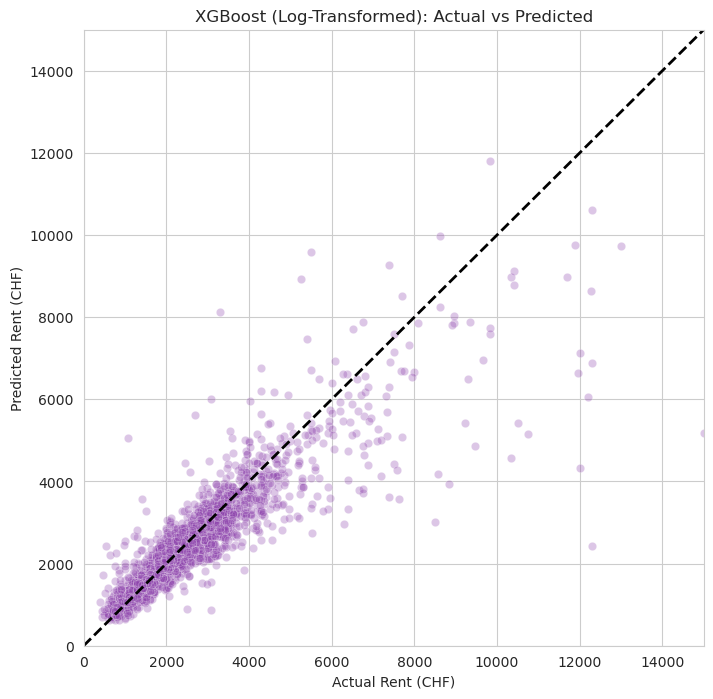

In [5]:
# 1. Predict with Best Model (Log Scale)
y_pred_log = best_model.predict(X_test)

# 2. Inverse Transform
y_pred_final = np.expm1(y_pred_log)

# 3. Metrics
mae_final = mean_absolute_error(y_test_original, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_original, y_pred_final))
r2_final = r2_score(y_test_original, y_pred_final)

print("-" * 30)
print("FINAL TUNED MODEL PERFORMANCE")
print(f"MAE:  {mae_final:.2f} CHF")
print(f"RMSE: {rmse_final:.2f} CHF")
print(f"R2:   {r2_final:.4f}")
print("-" * 30)

# Visual Check
plt.figure(figsize=(8, 8))
# Use y_test_original for x-axis
sns.scatterplot(x=y_test_original, y=y_pred_final, alpha=0.3, color='#8e44ad')
plt.plot([0, 15000], [0, 15000], 'k--', lw=2)
plt.title('XGBoost (Log-Transformed): Actual vs Predicted')
plt.xlabel('Actual Rent (CHF)')
plt.ylabel('Predicted Rent (CHF)')
plt.xlim(0, 15000)
plt.ylim(0, 15000)
plt.show()

## 5. Model Explainability (SHAP)
This is the most important section for a Data Scientist. We don't just want a prediction; we want to know **why**.
*   **SHAP Summary Plot:** Shows which features are the most important drivers of price globally.

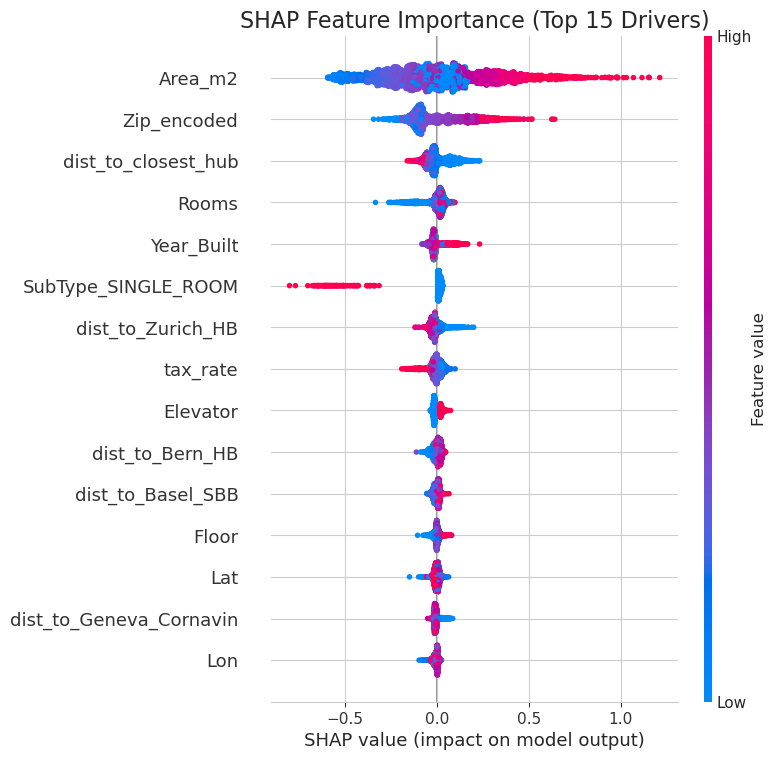

In [6]:
# 1. Create Explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# 2. Summary Plot (Beeswarm)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.title("SHAP Feature Importance (Top 15 Drivers)", fontsize=16)
plt.show()

### Interpretation
*   **Area_m2:** The red dots (high area) are on the far right (positive impact on price). This is the strongest driver.
*   **Zip_encoded:** Living in a high-value Zip code (red) massively increases price.
*   **Tax_Rate:** Lower tax rate (blue) should correlate with higher price (right side).
*   **Lake View:** Check the `has_lake_view` flag. Does it push prices up?

Generating Dependence Plots...


<Figure size 1000x600 with 0 Axes>

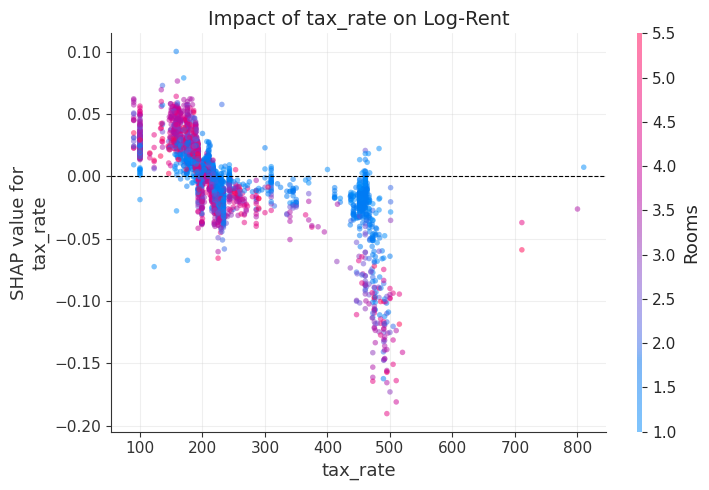

<Figure size 1000x600 with 0 Axes>

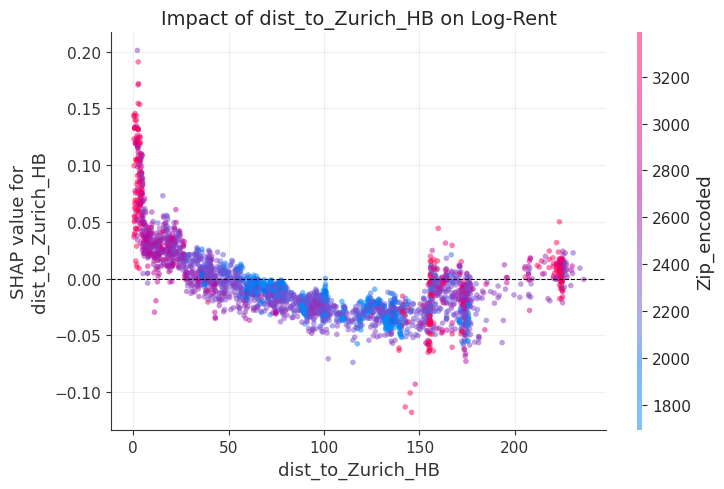

<Figure size 1000x600 with 0 Axes>

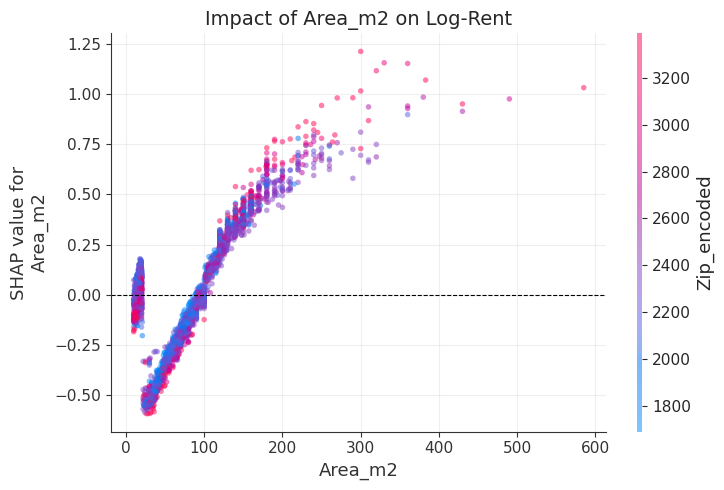

In [9]:
# ==============================================================================
# 5b. Deep Dive: Partial Dependence Plots (Swiss Features)
# ==============================================================================
# Goal: Validate that the model learned "Economic Reality" (e.g., Taxes, Commute).

import matplotlib.pyplot as plt

# We want to look at 3 specific "Swiss" drivers:
# 1. Tax Rate (The "Zug Effect")
# 2. Distance to Zurich (The "Commute Effect")
# 3. Living Area (The "Control" - should be linear-ish)

features_to_plot = ['tax_rate', 'dist_to_Zurich_HB', 'Area_m2']

print("Generating Dependence Plots...")

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    
    # SHAP Dependence Plot
    # interaction_index='auto' tries to find the feature that interacts most with the main feature
    # alpha=0.5 makes the dots transparent so you can see density
    shap.dependence_plot(
        feature, 
        shap_values, 
        X_test, 
        interaction_index='auto', 
        show=False, # Allows us to customize the plot before rendering
        alpha=0.5
    )
    
    plt.title(f'Impact of {feature} on Log-Rent', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Add a zero line for reference
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    
    plt.tight_layout()
    plt.show()

### Interpretation of Partial Dependence:

1. Fiscal Impact: The model confirms the "Tax Haven" hypothesis. Municipalities with lower tax multipliers command a rental premium, particularly for larger properties (High Room count), suggesting these areas specifically attract wealthier tenants seeking tax efficiency.
 
2. Geospatial Decay & Hubs: We observe a sharp non-linear price decay within the first 30km of Zurich. Interestingly, the model identifies a secondary price spike at ~200km distance, correctly identifying the Geneva market as an independent high-cost hub.

3. Structural Value: Living area exhibits a strong log-linear relationship with price, with the highest marginal utility observed in the 30-120m² range.

## 6. Export Model
We save the model and the encoder so we can build an interactive app (`app.py`).

In [7]:
# Save the model
with open('../models/xgb_rent_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the Zip Encoder (We need this to process user input in the app)
with open('../models/zip_encoder.pkl', 'wb') as f:
    pickle.dump(encoder_zip, f)

print("Model and Encoder saved to models/ folder.")

Model and Encoder saved to models/ folder.
